In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow.sklearn import save_model
import mlflow
import mlflow.sklearn
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score

In [104]:
#Some generals settings
warnings.filterwarnings('ignore')
mlflow.sklearn.autolog(log_input_examples=True, log_models=True, log_model_signatures=True)
mlflow.set_tracking_uri("http://localhost:5000")
experiment_id = mlflow.create_experiment("Mlflow Experience N°1")

RestException: RESOURCE_ALREADY_EXISTS: Experiment 'Mlflow Experience N°1' already exists.

In [102]:
def return_best_optimized_model(pipeline, parameters, train_x, train_y, test_x, test_y, scores_names, scores_obj):
    with mlflow.start_run(experiment_id=experiment_id, run_name="test") as run:
        gridsearch = GridSearchCV(estimator=pipeline, param_grid=parameters).fit(train_x, train_y)
        mlflow.log_metrics(return_evaluation_scores(gridsearch, scores_names, scores_obj, test_x, test_y))
    return gridsearch

def return_evaluation_scores(current_pipeline, scores_names, scores_obj, test_x, test_y):
    results = {}
    for name, obj in zip(scores_names, scores_obj):
        results[name] = obj(current_pipeline.predict(test_x), test_y)
    return results

In [53]:
#Generate signal
freq = 5
period = 1/freq
sample_number = 1000
time = 1
amplitude = 1000
times = np.linspace(0, time, sample_number)
x_values = np.linspace(0, 2*np.pi*(time/period), sample_number)
signal_values = np.sin(x_values)*amplitude

df_signal = pd.DataFrame()
df_signal["time"] = times
df_signal["signal"] = signal_values
df_signal.head()

,time,signal
0,0.000000,0.000000
1,0.001001,31.442191
2,0.002002,62.853290
3,0.003003,94.202236
4,0.004004,125.458030


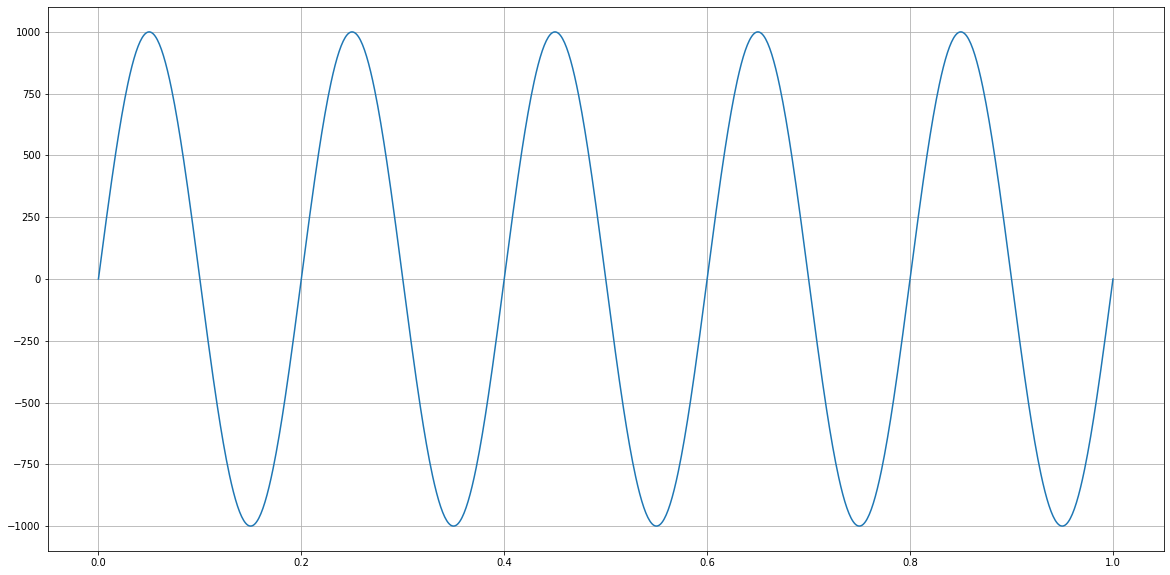

In [54]:
#Plot data
figure = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
ax.plot(df_signal["time"], df_signal["signal"])
ax.grid(True)

In [55]:
#Transformations (Wich can't be done in a Pipeline transformer --> Aggregations for instance)
good_shift = int(time/period)+1
print(good_shift)
df_signal["lag"] = df_signal["signal"].shift(good_shift)
df_signal = df_signal.dropna()
df_signal.head()

6


,time,signal,lag
6,0.006006,187.566653,0.000000
7,0.007007,218.358066,31.442191
8,0.008008,248.933554,62.853290
9,0.009009,279.262883,94.202236
10,0.010010,309.316061,125.458030


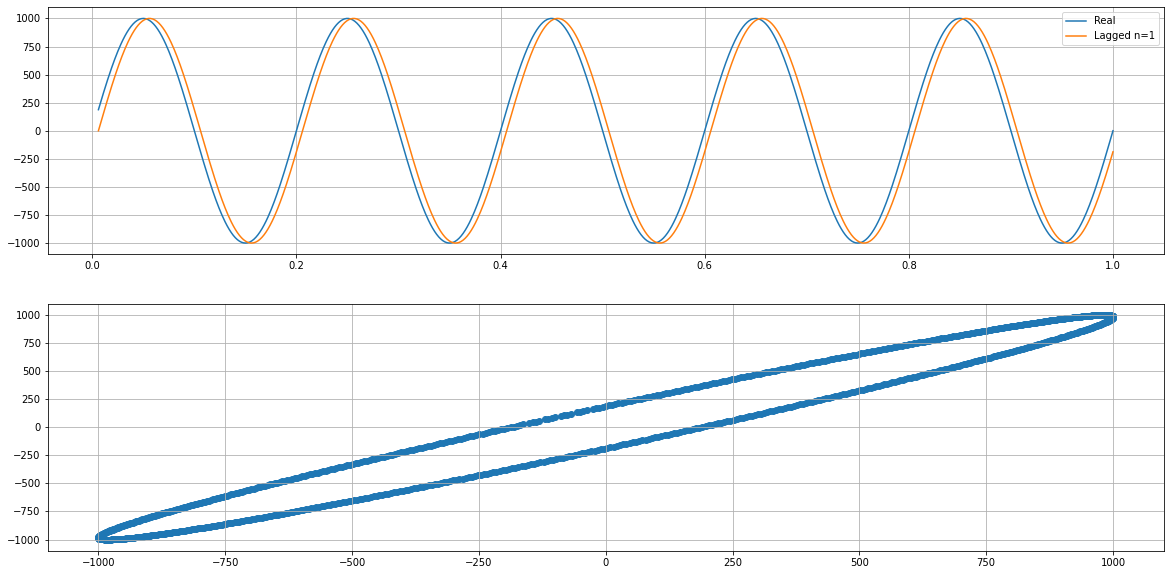

In [56]:
#Plot data
figure = plt.figure(figsize=(20, 10))
ax = plt.subplot(211)
ax.plot(df_signal["time"], df_signal["signal"], label="Real")
ax.plot(df_signal["time"], df_signal["lag"], label="Lagged n=1")
ax.legend(labels=["Real", "Lagged n=1"])
ax.grid(True)
ax = plt.subplot(212)
ax.scatter(df_signal["lag"], df_signal["signal"])
ax.grid(True)

In [57]:
#Split train and test
train, test = train_test_split(df_signal, test_size=0.30)
train_x = train.loc[:, ["lag"]]
train_y = train.loc[:, ["signal"]]
test_x = test.loc[:, ["lag"]]
test_y = test.loc[:, ["signal"]]

print("Train_x : {}, Test_x : {}\nTrain_y : {}, Test_y : {}".format(train_x.shape, test_x.shape, 
                                                                   train_y.shape, test_y.shape))

Train_x : (695, 1), Test_x : (299, 1)
Train_y : (695, 1), Test_y : (299, 1)


In [94]:
#Build all pipelines
all_models_name = ["Model_1", "Model_2"]
all_models_parameters = []
all_models_parameters.append(
{
    'pipeline' : Pipeline([
        ('Standardization', StandardScaler()),
        ('LinearRegression', RandomForestRegressor())
    ]),
    'parameters' : [
        {
            'LinearRegression__n_estimators' : range(1, 30)
        }
    ],
    "train_x" : train_x,
    "train_y" : train_y,
    "test_x" : test_x,
    "test_y" : test_y,
    
    "scores_names" : ["MSE", "Explained_variance"], 
    "scores_obj" : [mean_squared_error, explained_variance_score]  

})

all_models_parameters.append(
{
    'pipeline' : Pipeline([
        ('Standardization', StandardScaler()),
        ('LinearRegression', RandomForestRegressor())
    ]),
    'parameters' : [
        {
            'LinearRegression__n_estimators' : range(1, 30)
        }
    ],
    "train_x" : train_x,
    "train_y" : train_y,
    "test_x" : test_x,
    "test_y" : test_y,
    
    "scores_names" : ["MSE", "Explained_variance"], 
    "scores_obj" : [mean_squared_error, explained_variance_score]
    
})

In [101]:
all_bests_models = []
#Find bests Hyperparams for each pipelines
for name, model in zip(all_models_name, all_models_parameters):
    return_best_optimized_model(**model)

2021/07/29 15:31:40 INFO mlflow.sklearn.utils: Logging the 5 best runs, 24 runs will be omitted.


{'MSE': 46330.130692465624, 'Explained_variance': 0.9025526930962309}


2021/07/29 15:31:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 24 runs will be omitted.


{'MSE': 44613.18897494264, 'Explained_variance': 0.9062166998487716}
